# Calculating reflectivity from suspended graphene membranes

Rob Knobel, April 19 2017

Using information from Davidovikj et al., Nano Lett. 16(4) pp 2678-2733 (2016).

In [1]:
import matplotlib.pyplot as plt
from numpy import *
%matplotlib inline

This paper cites the 2007 paper by Blake et al. "Making Graphene Visible".  There the index of refraction for bulk graphite is used $n(\lambda)=2.6-1.3i$, which is independent of wavelength.  The thickness for a single layer of graphene is 0.34 nm.  The separation between planes in graphite is .335 nm (Wikipedia).  Thus I'll just use $n \times 0.34$ nm as the thickness for $n$ layers.

In [2]:
from scipy.optimize import curve_fit
from pylab import *

Aluminum optical data from Rakic, Applied Optics 24, 22 p4755 (1995).

In [4]:
al_optics = np.genfromtxt('aluminum_optics.csv', delimiter=',')

In [6]:
al_optics[0]

array([  6.19930000e-03,   2.00000000e+02,   4.23960000e+02,
         4.83700000e+02,   9.95910000e-01])

In [7]:
photon_energies=al_optics[:,0]

In [11]:
wavelengths=al_optics[:,1]/1e6

In [12]:
al_n=al_optics[:,2]

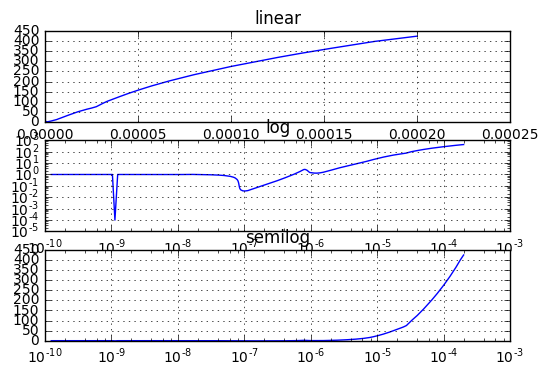

In [22]:
# plot with various axes scales
plt.figure(1)

# linear
plt.subplot(311)
plt.plot(wavelengths, al_n)
plt.yscale('linear')
plt.title('linear')
plt.grid(True)


# log
plt.subplot(312)
plt.plot(wavelengths, al_n)
plt.xscale('log')
plt.yscale('log')
plt.title('log')
plt.grid(True)


# semilog
plt.subplot(313)
plt.plot(wavelengths, al_n)
plt.xscale('log')
plt.title('semilog')
plt.grid(True)

plt.show()

In [23]:
al_k=al_optics[:,3]

In [24]:
al_R=al_optics[:,4]

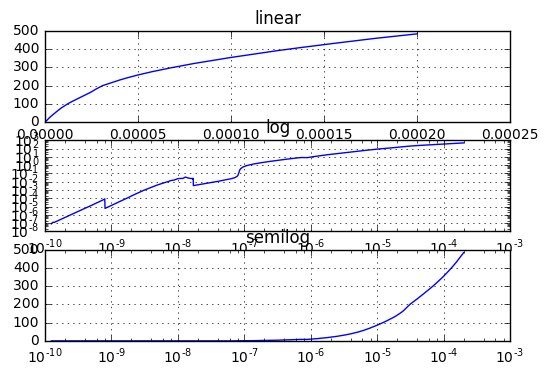

In [25]:
# plot with various axes scales
plt.figure(1)

# linear
plt.subplot(311)
plt.plot(wavelengths, al_k)
plt.yscale('linear')
plt.title('linear')
plt.grid(True)


# log
plt.subplot(312)
plt.plot(wavelengths, al_k)
plt.xscale('log')
plt.yscale('log')
plt.title('log')
plt.grid(True)


# semilog
plt.subplot(313)
plt.plot(wavelengths, al_k)
plt.xscale('log')
plt.title('semilog')
plt.grid(True)

plt.show()

The reflectivity from this paper is given as
$R = \frac{\left[n(\omega)-1\right]^2+k(\omega)^2}{\left[n(\omega)+1\right]^2+k(\omega)^2}$

For a semi-infinite piece of aluminum in air/vacuum.

In [57]:
refl_calc=((al_n-1)**2+al_k**2)/((al_n+1)**2+al_k**2)

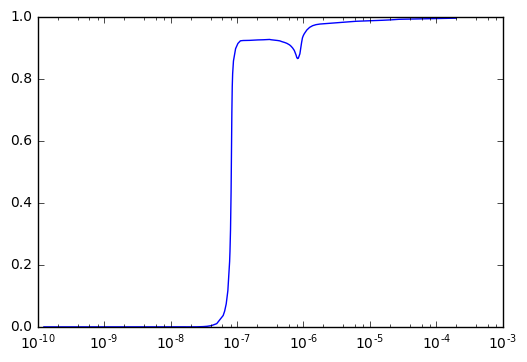

In [58]:
plt.plot(wavelengths,refl_calc)
plt.xscale('log')
plt.yscale('linear')
plt.show()

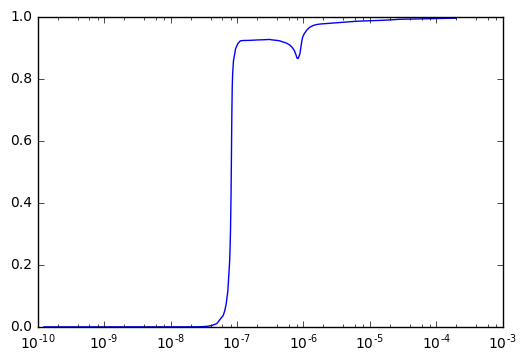

In [59]:
plt.plot(wavelengths,al_R)
plt.xscale('log')
plt.yscale('linear')
plt.show()

In [61]:
n_al = al_n + al_k*1j

In [63]:
n_vac=1+0j

In [64]:
n_graphene=2.6-1.3*1j

In [65]:
n_graphene

(2.6-1.3j)

In [103]:
from scipy.interpolate import interp1d

In [105]:
f_al_n = interp1d(wavelengths, al_n, kind='cubic')

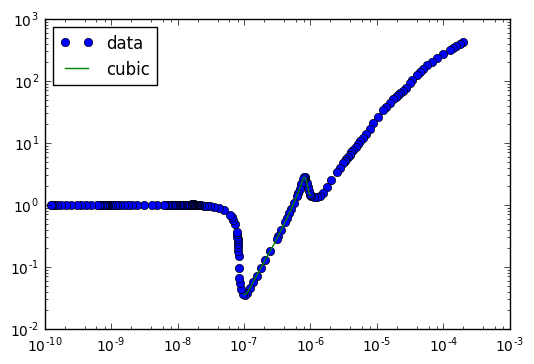

In [108]:
lamnew = linspace(100e-9, 1e-6, num=101, endpoint=True)
plt.plot(wavelengths, al_n, 'o', lamnew, f_al_n(lamnew), '-')
plt.legend(['data', 'cubic'], loc='best')
plt.xscale('log')
plt.yscale('log')
plt.show()

In [109]:
f_al_k = interp1d(wavelengths,al_k,kind='cubic')

In [111]:
def f_refl_calc(lam):
    "calculate the reflectivity of aluminum as a function of wavelength lam"
    return ((f_al_n(lam)-1)**2+f_al_k(lam)**2)/((f_al_n(lam)+1)**2+f_al_k(lam)**2)

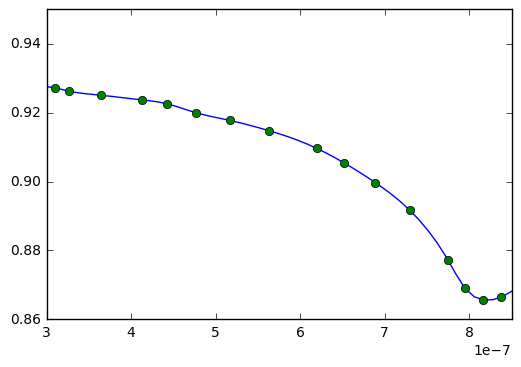

In [119]:
lam1 = linspace(300e-9,850e-9,51)
plt.plot(lam,f_refl_calc(lam),'-',wavelengths,refl_calc,'o')
plt.axis([300e-9,850e-9,.86,.95])
plt.show()

In [120]:
def f_n_al(lam):
    "returns the complex index of refraction of aluminum over a wide range from a cubic spline fit to data"
    return f_al_n(lam)+1j*f_al_k(lam)

In [121]:
def phi(n,d,lam):
    "Calculates the phase shift through a thickness of length d of a material with index n at wavelength lam"
    ph = 2*3.1415926*n*d/lam
    return ph;

To calculate the reflected intensity off a stack of layers, use the formula from Blake et al., "Making Graphene Visible", Appl. Phys. Lett. 91, 063124 (2007).

$I(n_1) = \left| \frac{r_1 e^{i(\Phi_1+\Phi_2)} + r_2 e^{-i(\Phi_1-\Phi_2)} +r_3 e^{-i(\Phi_1+\Phi_2)}
+ r_1 r_2 r_3 e^{i(\Phi_1-\Phi_2)}}{ e^{i(\Phi_1+\Phi_2)} + r_1 r_2 e^{-i(\Phi_1-\Phi_2)}+r_1 r_3 e^{-i(\Phi_1+\Phi_2)}
+r_2 r_3 e^{i(\Phi_1-\Phi_2)}}\right|^2$

Where $r_1 = \frac{n_0 - n_1}{n_0+n_1}$, $r_2 =\frac{n_1-n_2}{n_1+n_2}$, $r_3 = \frac{n_2-n_3}{n_2+n_3}$. 

In [122]:
phi(n_graphene,1*.34e-9,633e-9)

(0.008774621985466035-0.0043873109927330175j)

In [123]:
r1 = (1-n_graphene)/(1+n_graphene)

In [124]:
r2 = (n_graphene-1)/(n_graphene+1)

In [125]:
def r3(lam):
    "calculate the r3 term from the Blake et al paper for aluminum with vacuum above"
    return (1-f_n_al(lam))/(1+f_n_al(lam))

In [126]:
def intensity(gap,numlayers,lam):
    "Calculate the reflected intensity for a suspended graphene membrane numlayers thick, gap above aluminum at wavelength lam"
    p1= phi(n_graphene,numlayers*.34e-9,lam)
    p2 = phi(1,gap,lam)
    int1 = (r1*exp(1j*(p1+p2))+r2*exp(-1j*(p1-p2))+r3(lam)*exp(-1j*(p1+p2))+r1*r2*r3(lam)*exp(1j*(p1-p2)))/ (exp(1j*(p1+p2))+r1*r2*exp(-1j*(p1-p2))+r1*r3(lam)*exp(-1j*(p1+p2))+r2*r3(lam)*exp(1j*(p1-p2)))
    return int1*conjugate(int1)

C:\Users\Rob Knobel\Anaconda3\lib\site-packages\numpy\core\numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


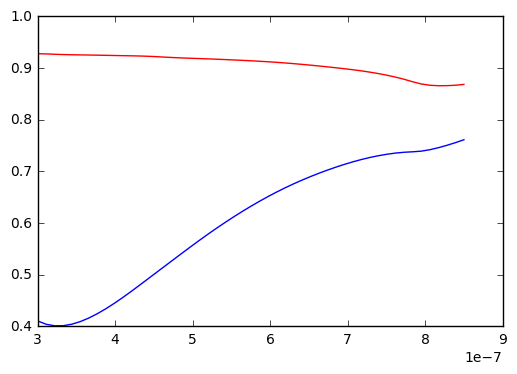

In [130]:
plt.plot(lam1,intensity(100e-9,5,lam1),'b',lam1,f_refl_calc(lam1),'r')

plt.show()

C:\Users\Rob Knobel\Anaconda3\lib\site-packages\numpy\core\numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


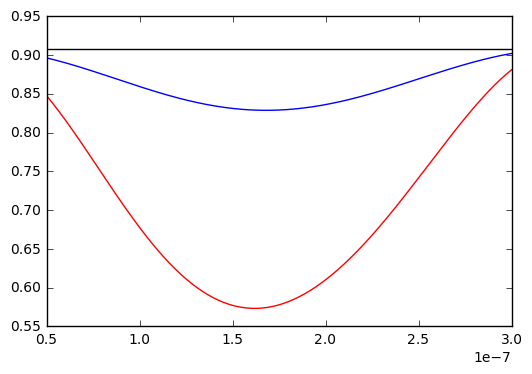

In [135]:
gaps=linspace(50e-9,300e-9,251)
plt.plot(gaps,intensity(gaps,1,633e-9),'b',gaps,intensity(gaps,5,633e-9),'r',gaps,f_refl_calc(633e-9)+0*intensity(gaps,5,633e-9),'k')

To calculate the reflection off a suspended graphene membrane without an aluminum layer behind, we can use a simular formulation.  Here we say that the reflected light intensity is given by the same formula as above, but we'll just plug $n_2=n_3$.

$I(n_a) = \left| \frac{r_1 e^{i(\Phi_1+\Phi_2)} + r_2 e^{-i(\Phi_1-\Phi_2)} +r_3 e^{-i(\Phi_1+\Phi_2)}
+ r_1 r_2 r_3 e^{i(\Phi_1-\Phi_2)}}{ e^{i(\Phi_1+\Phi_2)} + r_1 r_2 e^{-i(\Phi_1-\Phi_2)}+r_1 r_3 e^{-i(\Phi_1+\Phi_2)}
+r_2 r_3 e^{i(\Phi_1-\Phi_2)}}\right|^2$

Where $r_1 = \frac{n_0 - n_1}{n_0+n_1}$, $r_2 =\frac{n_1-n_2}{n_1+n_2}$, $r_3 = \frac{n_2-n_3}{n_2+n_3}$. 

Here $n_0=n_2=n_3=1$ is vacuum, $n_1= 2.6-1.3i$ is graphene.

In [136]:
r1 = (1-n_graphene)/(1+n_graphene)

In [137]:
r2 = (n_graphene-1)/(n_graphene+1)

In [138]:
r3b = 0

In [97]:
refl = empty([1,len(wavelengths)])
for d in gaps:
    append(refl,intensity(d,1,wavelengths))

In [95]:
refl=empty([1,len(wavelengths)])

In [101]:
refl

array([[-2.69897   , -2.7517324 , -2.8129025 , -2.86087687, -2.90308999,
        -3.00001737, -3.09690458, -3.1760956 , -3.24302936, -3.30103   ,
        -3.35218686, -3.39794001, -3.4771256 , -3.50869435, -3.55984687,
        -3.60560086, -3.64698829, -3.68478561, -3.71953545, -3.7517324 ,
        -3.80972434, -3.86087687, -3.90661334, -3.9858156 , -4.05275749,
        -4.11074873, -4.16190056, -4.20765735, -4.24905213, -4.2868456 ,
        -4.3216    , -4.35379239, -4.38375561, -4.41178433, -4.43811187,
        -4.46293686, -4.48640955, -4.50869435, -4.55984687, -4.60560086,
        -4.68478561, -4.7517324 , -4.80972434, -4.86087687, -4.90661334,
        -4.94803755, -4.9858156 , -5.00005212, -5.01384208, -5.02720492,
        -5.0401671 , -5.05275749, -5.07689075, -5.08847486, -5.09975307,
        -5.11074873, -5.13708188, -5.16190056, -5.18558591, -5.20765735,
        -5.24905213, -5.2868456 , -5.3216    , -5.35379239, -5.38375561,
        -5.43811187, -5.48640955, -5.50869435, -5.6